# Pseudo Labeling

## Set up

In [ ]:
import os
import json
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

from sklearn.semi_supervised import SelfTrainingClassifier

PATH = Path.cwd().parents[2]

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(PATH))

from scripts.feature_extractions.tf_idf import extract_tf_idf_for_unlabeled
from scripts.feature_extractions.n_grams import extract_n_grams_for_unlabeled


In [2]:
MODEL_PATH = os.path.join(PATH, 'models/1_groundtruth_with_large')
DATA_PATH = os.path.join(PATH, 'data')
BASE_PATH  = os.path.join(DATA_PATH, 'external/crpwarner')
MERGE_PATH = os.path.join(BASE_PATH, 'merged')
LARGE_PATH = os.path.join(BASE_PATH, 'large')
SAVE_PATH = os.path.join(DATA_PATH, 'interim/crpwarner/pseudo-label')

In [3]:
mint_df = pd.read_csv(os.path.join(MERGE_PATH, 'mint.csv')).set_index('address')
leak_df = pd.read_csv(os.path.join(MERGE_PATH, 'leak.csv')).set_index('address')
limit_df = pd.read_csv(os.path.join(MERGE_PATH, 'limit.csv')).set_index('address')

sol_path_list = list(Path(os.path.join(LARGE_PATH, 'sol')).glob('*.sol'))
merged_sol_path_list = list(Path(os.path.join(MERGE_PATH, 'sol')).glob('*.sol'))
hex_path_list = list(Path(os.path.join(LARGE_PATH, 'hex')).glob('*.hex'))
merged_hex_path_list = list(Path(os.path.join(MERGE_PATH, 'hex')).glob('*.hex'))

data = {
  'mint': mint_df.index,
  'leak': leak_df.index,
  'limit': limit_df.index
}

## Mint

### Load Model

In [4]:
name = 'mint'

In [5]:
model = pickle.load(open(list(Path(MODEL_PATH).glob(f'{name}-*.pkl'))[0], 'rb'))

In [6]:
with open(list(Path(MODEL_PATH).glob(f'{name}-*.json'))[0], 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)

In [7]:
feature_cols[:5], len(feature_cols)

(['spdx', 'license', 'identifier', 'mit', 'pragma'], 2000)

### Labelling

In [8]:
unlabeled_record = []
unlabelled_files = []
labelled_files = [path for path in merged_sol_path_list if path.stem in data[name]]

for sol_path in sol_path_list:
    address = sol_path.stem
    if address not in data[name]:
        unlabelled_files.append(sol_path)
        record = dict()
        record['address'] = address
        unlabeled_record.append(record)

df_unlabeled = pd.DataFrame(unlabeled_record)

In [9]:
df_unlabeled.head()

,address
0,0x8810c63470d38639954c6b41aac545848c46484a
1,0x30df12e5f1f5b327e385f5f48736aff5a1e52103
2,0x49b84450a9a56081ce570920aa578c35e0b2461f
3,0xa46630a30a77d27607fc05b62da2ef291fc1460c
4,0xc22e162db0b8b55486160c35064f91e418cc2221


In [10]:
X_labeled = extract_tf_idf_for_unlabeled(labelled_files, feature_cols)
y_labeled = mint_df['TP?'].values

  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 161/161 [00:00<00:00, 1798.10it/s]


In [11]:
X_unlabeled = extract_tf_idf_for_unlabeled(unlabelled_files, feature_cols)
y_unlabeled = np.full(X_unlabeled.shape[0], -1)

100%|██████████| 13390/13390 [00:06<00:00, 2202.54it/s]


In [12]:
print(X_labeled.shape, y_labeled.shape)
print(X_unlabeled.shape, y_unlabeled.shape)


(161, 2000) (161,)
(13390, 2000) (13390,)


In [13]:
X_combined = np.vstack([X_labeled.toarray(), X_unlabeled.toarray()])
y_combined = np.concatenate((y_labeled, y_unlabeled))

In [14]:
threshold = 0.9

In [15]:
self_training_model = SelfTrainingClassifier(model, threshold=threshold)
self_training_model.fit(X_combined, y_combined)

SelfTrainingClassifier(base_estimator=KNeighborsClassifier(), threshold=0.9)

In [16]:
pseudo_labels = self_training_model.predict(X_unlabeled)
probas = self_training_model.predict_proba(X_unlabeled)
confidence = np.max(probas, axis=1)
high_conf_idx = confidence >= threshold

# Filtered pseudo-labeled contracts
X_pseudo = X_unlabeled[high_conf_idx]
labels_pseudo = pseudo_labels[high_conf_idx]
conf_pseudo = confidence[high_conf_idx]
df_pseudo = df_unlabeled.iloc[high_conf_idx].copy()
df_pseudo['TP?'] = labels_pseudo
df_pseudo['confidence'] = conf_pseudo


In [17]:
f"{len(df_pseudo)} high-confidence pseudo-labeled contracts"


'10953 high-confidence pseudo-labeled contracts'

<Axes: xlabel='TP?', ylabel='count'>

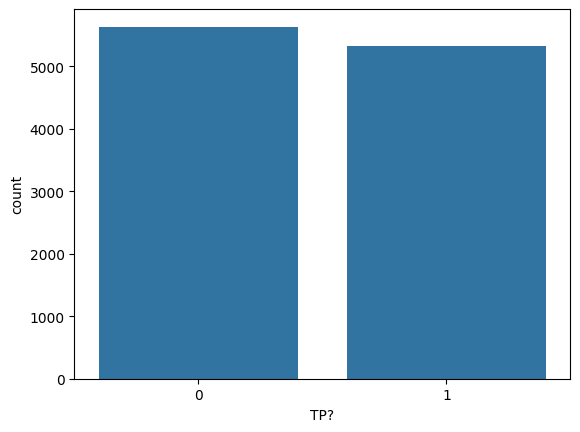

In [18]:
sns.countplot(x="TP?", data=df_pseudo)

### Save

In [19]:
df_pseudo.to_csv(os.path.join(SAVE_PATH, f'{name}-self-learning.csv'), index=False)

## Leak

### Load Model

In [21]:
name = 'leak'

In [22]:
model = pickle.load(open(list(Path(MODEL_PATH).glob(f'{name}-*.pkl'))[0], 'rb'))

In [23]:
with open(list(Path(MODEL_PATH).glob(f'{name}-*.json'))[0], 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)

In [24]:
feature_cols[:5], len(feature_cols)

(['spdx', 'license', 'identifier', 'mit', 'pragma'], 3000)

### Labelling

In [25]:
unlabeled_record = []
unlabelled_files = []
labelled_files = [path for path in merged_sol_path_list if path.stem in data[name]]

for sol_path in sol_path_list:
    address = sol_path.stem
    if address not in data[name]:
        unlabelled_files.append(sol_path)
        record = dict()
        record['address'] = address
        unlabeled_record.append(record)

df_unlabeled = pd.DataFrame(unlabeled_record)

In [26]:
df_unlabeled.head()

,address
0,0x8810c63470d38639954c6b41aac545848c46484a
1,0x30df12e5f1f5b327e385f5f48736aff5a1e52103
2,0x49b84450a9a56081ce570920aa578c35e0b2461f
3,0xa46630a30a77d27607fc05b62da2ef291fc1460c
4,0xc22e162db0b8b55486160c35064f91e418cc2221


In [27]:
X_labeled = extract_tf_idf_for_unlabeled(labelled_files, feature_cols)
y_labeled = leak_df['TP?'].values

100%|██████████| 156/156 [00:00<00:00, 1672.24it/s]


In [28]:
X_unlabeled = extract_tf_idf_for_unlabeled(unlabelled_files, feature_cols)
y_unlabeled = np.full(X_unlabeled.shape[0], -1)

100%|██████████| 13395/13395 [00:01<00:00, 8966.12it/s] 


In [29]:
print(X_labeled.shape, y_labeled.shape)
print(X_unlabeled.shape, y_unlabeled.shape)


(156, 3000) (156,)
(13395, 3000) (13395,)


In [30]:
X_combined = np.vstack([X_labeled.toarray(), X_unlabeled.toarray()])
y_combined = np.concatenate((y_labeled, y_unlabeled))

In [31]:
self_training_model = SelfTrainingClassifier(model, threshold=0.8)
self_training_model.fit(X_combined, y_combined)

[LightGBM] [Info] Number of positive: 83, number of negative: 73
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12664
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 688
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532051 -> initscore=0.128381
[LightGBM] [Info] Start training from score 0.128381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

SelfTrainingClassifier(base_estimator=LGBMClassifier(random_state=42),
                       threshold=0.8)

In [32]:
pseudo_labels = self_training_model.predict(X_unlabeled)
probas = self_training_model.predict_proba(X_unlabeled)
confidence = np.max(probas, axis=1)
threshold = 0.8
high_conf_idx = confidence >= threshold

# Filtered pseudo-labeled contracts
X_pseudo = X_unlabeled[high_conf_idx]
labels_pseudo = pseudo_labels[high_conf_idx]
conf_pseudo = confidence[high_conf_idx]
df_pseudo = df_unlabeled.iloc[high_conf_idx].copy()
df_pseudo['TP?'] = labels_pseudo
df_pseudo['confidence'] = conf_pseudo


In [33]:
f"{len(df_pseudo)} high-confidence pseudo-labeled contracts"


'13265 high-confidence pseudo-labeled contracts'

<Axes: xlabel='TP?', ylabel='count'>

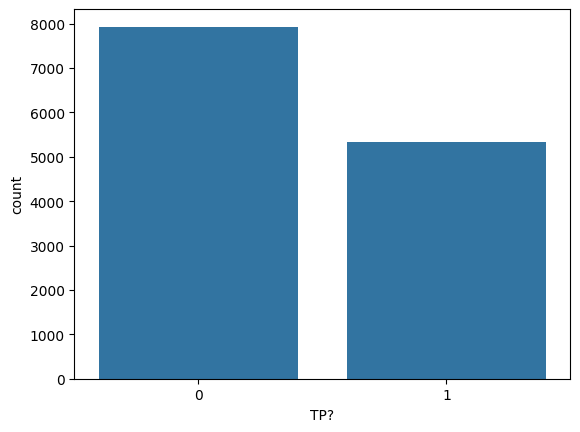

In [34]:
sns.countplot(x="TP?", data=df_pseudo)

### Save

In [35]:
df_pseudo.to_csv(os.path.join(SAVE_PATH, f'{name}-self-learning.csv'), index=False)

## Limit

### Load Model

In [36]:
name = 'limit'

In [37]:
model = pickle.load(open(list(Path(MODEL_PATH).glob(f'{name}-*.pkl'))[0], 'rb'))

In [38]:
with open(list(Path(MODEL_PATH).glob(f'{name}-*.json'))[0], 'r', encoding='utf-8') as f:
    feature_cols = json.load(f)

In [39]:
feature_cols[:5], len(feature_cols)

(['add add',
  'add and',
  'add and dup',
  'add calldataload',
  'add calldataload push'],
 1000)

### Labelling

In [40]:
unlabeled_record = []
unlabelled_files = []
labelled_files = [path for path in merged_hex_path_list if path.stem in data[name]]

for hex_path in hex_path_list:
    address = hex_path.stem
    if address not in data[name]:
        unlabelled_files.append(hex_path)
        record = dict()
        record['address'] = address
        unlabeled_record.append(record)

df_unlabeled = pd.DataFrame(unlabeled_record)

In [41]:
df_unlabeled.head()

,address
0,0x71a982a028c9d4b0566041a78df12b810462e155
1,0x9b11efcaaa1890f6ee52c6bb7cf8153ac5d74139
2,0x9ec8d44af808d7cca2ec23c0dc0d1f49a3386ea4
3,0x662abcad0b7f345ab7ffb1b1fbb9df7894f18e66
4,0x21f15966e07a10554c364b988e91dab01d32794a


In [42]:
X_labeled = extract_tf_idf_for_unlabeled(labelled_files, feature_cols)
y_labeled = limit_df['TP?'].values

100%|██████████| 160/160 [00:00<00:00, 1714.59it/s]


In [43]:
X_unlabeled = extract_n_grams_for_unlabeled(unlabelled_files, feature_cols)
y_unlabeled = np.full(X_unlabeled.shape[0], -1)

  0%|          | 5/13392 [00:00<05:19, 41.92it/s]invalid instruction: PUSH30
invalid instruction: PUSH22
invalid instruction: PUSH24
  0%|          | 10/13392 [00:00<05:20, 41.71it/s]invalid instruction: PUSH27
invalid instruction: PUSH17
  0%|          | 15/13392 [00:00<08:45, 25.45it/s]invalid instruction: PUSH21
invalid instruction: PUSH17
  0%|          | 21/13392 [00:00<06:40, 33.34it/s]invalid instruction: PUSH19
invalid instruction: PUSH32
  0%|          | 26/13392 [00:00<06:11, 35.98it/s]invalid instruction: PUSH13
invalid instruction: PUSH24
  0%|          | 31/13392 [00:00<06:55, 32.13it/s]invalid instruction: PUSH28
invalid instruction: PUSH16
invalid instruction: PUSH24
invalid instruction: PUSH11
invalid instruction: PUSH29
  0%|          | 38/13392 [00:01<05:26, 40.84it/s]invalid instruction: PUSH23
invalid instruction: PUSH31
invalid instruction: PUSH29
  0%|          | 43/13392 [00:01<06:42, 33.13it/s]invalid instruction: PUSH28
invalid instruction: PUSH13
  0%|        

In [44]:
print(X_labeled.shape, y_labeled.shape)
print(X_unlabeled.shape, y_unlabeled.shape)


(160, 1000) (160,)
(13392, 1000) (13392,)


In [45]:
X_combined = np.vstack([X_labeled.toarray(), X_unlabeled.toarray()])
y_combined = np.concatenate((y_labeled, y_unlabeled))

In [46]:
self_training_model = SelfTrainingClassifier(model, threshold=0.6)
self_training_model.fit(X_combined, y_combined)

SelfTrainingClassifier(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    device=None,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None,
                                                    feature_types=None,
                                                    gamma=None,
                                                    grow_policy=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_bin=None,
                                                    max_cat_threshold=None,
                                                    max_cat_to_onehot=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    max_leaves=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    multi_strategy=None,
                                                    n_estimators=None,
                                                    n_jobs=None,
                                                    num_parallel_tree=None,
                                                    random_state=42, ...),
                       threshold=0.6)

In [47]:
pseudo_labels = self_training_model.predict(X_unlabeled)
probas = self_training_model.predict_proba(X_unlabeled)
confidence = np.max(probas, axis=1)
threshold = 0.6
high_conf_idx = confidence >= threshold

# Filtered pseudo-labeled contracts
X_pseudo = X_unlabeled[high_conf_idx]
labels_pseudo = pseudo_labels[high_conf_idx]
conf_pseudo = confidence[high_conf_idx]
df_pseudo = df_unlabeled.iloc[high_conf_idx].copy()
df_pseudo['TP?'] = labels_pseudo
df_pseudo['confidence'] = conf_pseudo


In [48]:
f"{len(df_pseudo)} high-confidence pseudo-labeled contracts"


'13392 high-confidence pseudo-labeled contracts'

<Axes: xlabel='TP?', ylabel='count'>

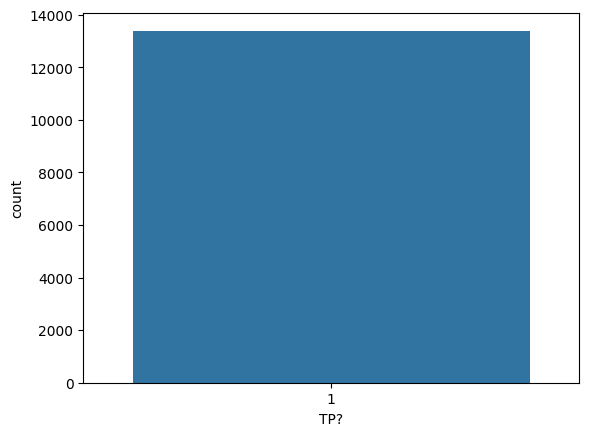

In [49]:
sns.countplot(x="TP?", data=df_pseudo)

### Save

In [50]:
df_pseudo.to_csv(os.path.join(SAVE_PATH, f'{name}-self-learning.csv'), index=False)